In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import copy
import math
import time
import random

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

from common.optim.meta import MetaData
from common.optim.optimise_v7_flight import NetLineStepProcessor
from common.util import AverageMeter, loss_crossentropy_np
from common.lr_scheduling import cosine_annealing4_lr, cosine_annealing2_lr, cosine_annealing3_lr
from common.cnn import make_resnet9

from torchvision.datasets import CIFAR10
from torchvision import transforms

import logging

In [3]:
logging.basicConfig(filename="logs/cifar10_restnet9_fast.log",
                level=logging.INFO,
                format="%(levelname)s: %(asctime)s %(message)s")


#### Constants

In [4]:
BATCH_SIZE = 128
SAMPLE_SIZE = 1024
OUTPUT_DIM = 10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EXPERIMENTS = 3 #10
EPOCHS_PER_EXPERIMENT = 50
DATASET_PATH = "./datasets"

torch.manual_seed(641)
random.seed(641)

#### CIFAR10 dataset

In [5]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(*stats,inplace=True)])
valid_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=train_transforms)
test_dataset = CIFAR10(root=DATASET_PATH, train=False, download=True, transform=valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, num_workers=0, pin_memory=True)

100%|██████████| 170M/170M [00:04<00:00, 38.7MB/s]


##### UTILS

In [6]:
def calculate_accuracy(prediction, target):
    # Note that prediction.shape == target.shape == [B, ]
    matching = (prediction == target).float()
    return matching.mean().item()

def test_loop(testNet):
    accuracy_meter, loss_meter  = AverageMeter(), AverageMeter()
    testNet.train(False)
    with torch.no_grad():
        for test_batch in test_dataloader:
            images, labels = test_batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                logits = testNet.forward(images)
                loss = F.cross_entropy(logits, labels)
                loss_meter.update(loss)

                prediction = logits.argmax(dim=-1)
                accuracy_meter.update(calculate_accuracy(prediction, labels))

    return accuracy_meter.avg, loss_meter.avg

#### Compare optimisers

In [7]:
def experiment_comparison(data, low, high, title="Comparison"):

    MEAN_ADAM = data[low:high,0]
    MEAN_NETLINE = data[low:high,1]
    MEAN_SGD = data[low:high,2]

    #display.clear_output()
    fig, axes = plt.subplots(4, 2, figsize=(18, 30))
    axes[0,0].set_title('Loss (average cross entropy)')
    axes[0,0].plot(MEAN_ADAM[:,1], color='g',alpha=.5, label='Adam')
    axes[0,0].plot(MEAN_NETLINE[:,1], color='b',alpha=.5, label='Net-line')
    axes[0,0].plot(MEAN_SGD[:,1], color='grey', alpha=.5, label='SGD')
    axes[0,0].grid()
    axes[0,0].set_yscale("log")
    axes[0,0].legend()
    axes[0,0].set_xlabel("Epoch (series of gradient descent steps)")
    axes[0,0].set_ylabel("Loss value")

    axes[0,1].set_title('Error (top 1)')
    axes[0,1].plot(1.0-MEAN_ADAM[:,0], color='g', alpha=.5, label='Adam')
    axes[0,1].plot(1.0-MEAN_NETLINE[:,0], color='b', alpha=.5, label='Net-line')
    axes[0,1].plot(1.0-MEAN_SGD[:,0], color='grey', alpha=.5, label='SGD')
    axes[0,1].grid()
    axes[0,1].set_yscale("log")
    axes[0,1].legend()
    axes[0,1].set_xlabel("Epoch (series of gradient descent steps)")
    axes[0,1].set_ylabel("Error value")

    axes[1,0].set_title('PQ vector norm')
    axes[1,0].plot(MEAN_NETLINE[:,4], color='grey',alpha=.5, label='PQ vector norm average per epoch')

    axes[1,1].set_title('QQ vector norm')
    axes[1,1].set_yscale("log")
    axes[1,1].plot(MEAN_NETLINE[:,3], color='green',alpha=.5, label='QQ1 vector norm average per epoch')

    axes[2,0].set_title('Cos phi and kappa min/avg')
    axes[2,0].plot(MEAN_NETLINE[:,5], color='green',alpha=.5, label='Cos phi average per epoch')
    axes[2,0].plot(MEAN_NETLINE[:,9], color='blue',alpha=.5, label='Kappa average per epoch')
    axes[2,0].plot(MEAN_NETLINE[:,10], color='red',alpha=.5, label='Kappa_min average per epoch')
    axes[2,0].plot(MEAN_NETLINE[:,15], color='magenta',alpha=.5, label='alpha average per epoch')
    axes[2,0].grid()
    axes[2,0].legend()

    axes[2,1].set_title('Eta calculated')
    axes[2,1].set_yscale("log")
    axes[2,1].plot(MEAN_NETLINE[:,6], color='green',alpha=.5, label='Eta average per epoch')
    axes[2,1].plot(MEAN_SGD[:,6], color='red',alpha=.5, label='Eta SGD average per epoch')
    axes[2,1].grid()
    axes[2,1].legend()

    axes[3,0].set_title('Grad norm2')
    axes[3,0].set_yscale("log")
    axes[3,0].plot(MEAN_NETLINE[:,11], color='green',alpha=.5, label='Grad norm2')
    axes[3,0].plot(MEAN_NETLINE[:,13], color='blue',alpha=.5, label='Accum grad norm2')
    axes[3,0].plot(MEAN_SGD[:,11], color='red',alpha=.5, label='Grad SGD norm2')
    axes[3,0].grid()
    axes[3,0].legend()

    axes[3,1].set_title('Grad norm2 variance')
    axes[3,1].set_yscale("log")
    axes[3,1].plot(MEAN_NETLINE[:,12], color='green',alpha=.5, label='Grad norm2 variance')
    axes[3,1].plot(MEAN_NETLINE[:,14], color='blue',alpha=.5, label='Accum grad norm2 variance')
    axes[3,1].plot(MEAN_SGD[:,12], color='red',alpha=.5, label='Grad SGD norm2 variance')
    axes[3,1].grid()
    axes[3,1].legend()

    dummy=fig.suptitle(title)
    plt.show()

def experiments_comparison(data, var, low, high, title="Comparison"):

    MEAN_ADAM = data[low:high,0]
    MEAN_NETLINE = data[low:high,1]
    MEAN_SGD = data[low:high,2]
    lowB, upB = data[low:high]-var[low:high], data[low:high]+var[low:high]
    LOW_ADAM, UP_ADAM = lowB[:,0], upB[:,0]
    LOW_NETLINE, UP_NETLINE = lowB[:,1], upB[:,1]
    LOW_SGD, UP_SGD = lowB[:,2], upB[:,2]
    cord_x = np.arange(0, len(MEAN_ADAM[:,1]))

    #display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].set_title('Loss (average cross entropy)')
    axes[0].plot(MEAN_ADAM[:,1], color='g',alpha=.5, label='Adam')
    if (var is not None):
        axes[0].fill_between(x=cord_x, y1=LOW_ADAM[:,1], y2=UP_ADAM[:,1], color='g', alpha=.125)
    axes[0].plot(MEAN_NETLINE[:,1], color='b',alpha=.5, label='Net-line')
    if (var is not None):
        axes[0].fill_between(x=cord_x, y1=LOW_NETLINE[:,1], y2=UP_NETLINE[:,1], color='b', alpha=.125)
    axes[0].plot(MEAN_SGD[:,1], color='grey', alpha=.5, label='SGD')
    if (var is not None):
        axes[0].fill_between(x=cord_x, y1=LOW_SGD[:,1], y2=UP_SGD[:,1], color='grey', alpha=.125)
    axes[0].grid()
    axes[0].set_yscale("log")
    axes[0].legend()
    axes[0].set_xlabel("Epoch (series of gradient descent steps)")
    axes[0].set_ylabel("Loss value")

    axes[1].set_title('Error (top 1)')
    axes[1].plot(1.0-MEAN_ADAM[:,0], color='g', alpha=.5, label='Adam')
    if (var is not None):
        axes[1].fill_between(x=cord_x, y1=1.0-LOW_ADAM[:,0], y2=1.0-UP_ADAM[:,0], color='g', alpha=.125)
    axes[1].plot(1.0-MEAN_NETLINE[:,0], color='b', alpha=.5, label='Net-line')
    if (var is not None):
        axes[1].fill_between(x=cord_x, y1=1.0-LOW_NETLINE[:,0], y2=1.0-UP_NETLINE[:,0], color='b', alpha=.125)
    axes[1].plot(1.0-MEAN_SGD[:,0], color='grey', alpha=.5, label='SGD')
    if (var is not None):
        axes[1].fill_between(x=cord_x, y1=1.0-LOW_SGD[:,0], y2=1.0-UP_SGD[:,0], color='grey', alpha=.125)
    axes[1].grid()
    axes[1].set_yscale("log")
    axes[1].legend()
    axes[1].set_xlabel("Epoch (series of gradient descent steps)")
    axes[1].set_ylabel("Error value")

    dummy=fig.suptitle(title)
    plt.show()

def timing_comparison(data, low, high, title="Comparison"):
    TIMING_ADAM = data[low:high,0]
    TIMING_NETLINE = data[low:high,1]
    TIMING_SGD = data[low:high,2]

    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    axes.set_title(title)
    axes.plot(TIMING_ADAM[:,2], color='g',alpha=.5, label='Adam')
    axes.plot(TIMING_NETLINE[:,2], color='b',alpha=.5, label='Net-line')
    axes.plot(TIMING_SGD[:,2], color='grey', alpha=.5, label='SGD')
    axes.grid()
    axes.legend()
    axes.set_xlabel("Epoch (series of gradient descent steps)")
    axes.set_ylabel("Time ns")
    plt.show()

def rf(value):
    return f"{value:.5f}"

def accuracy_comparison(exp_results, low, high, title="Validation accuracy"):
    adam_mean, adam_var = np.mean(exp_results[:, low:high, 0, 0], axis=0), np.var(exp_results[:, low:high, 0, 0], axis=0)
    nline_mean, nline_var = np.mean(exp_results[:, low:high, 1, 0], axis=0), np.var(exp_results[:, low:high, 1, 0], axis=0)
    sgd_mean, sgd_var = np.mean(exp_results[:, low:high, 2, 0], axis=0), np.var(exp_results[:, low:high, 2, 0], axis=0)

    p1, p2, p3, p4, p5 = min(10,EPOCHS_PER_EXPERIMENT), min(20,EPOCHS_PER_EXPERIMENT), min(30,EPOCHS_PER_EXPERIMENT)\
        , min(40,EPOCHS_PER_EXPERIMENT), min(50,EPOCHS_PER_EXPERIMENT)

    report = np.zeros((3,5), dtype='U256')
    for row in range(3):
        mean, var = (adam_mean, adam_var) if row == 0 else (nline_mean, nline_var) if row == 1 else (sgd_mean, sgd_var)
        for col in range(5):
            indx = p1-1 if col == 0 else p2-1 if col == 1 else p3-1 if col == 2 else p4-1 if col == 3 else p5-1
            report[row, col] = rf(mean[indx]) + "+/-" + rf(var[indx])

    fig, ax = plt.subplots(figsize=(8, 8))
    # hide axes
    #fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    tab_plot = ax.table(cellText=report, colLabels=[str(p1)+' epochs',str(p2)+' epochs',str(p3)+' epochs',str(p4)+' epochs',str(p5)+' epochs']\
        , rowLabels=['Adam','Net-line','SGD'], cellLoc='left', loc='center')
    tab_plot.auto_set_font_size(False)
    tab_plot.set_fontsize(11)
    tab_plot.scale(3, 5)
    #fig.tight_layout()
    ax.set_title(title)
    plt.show()


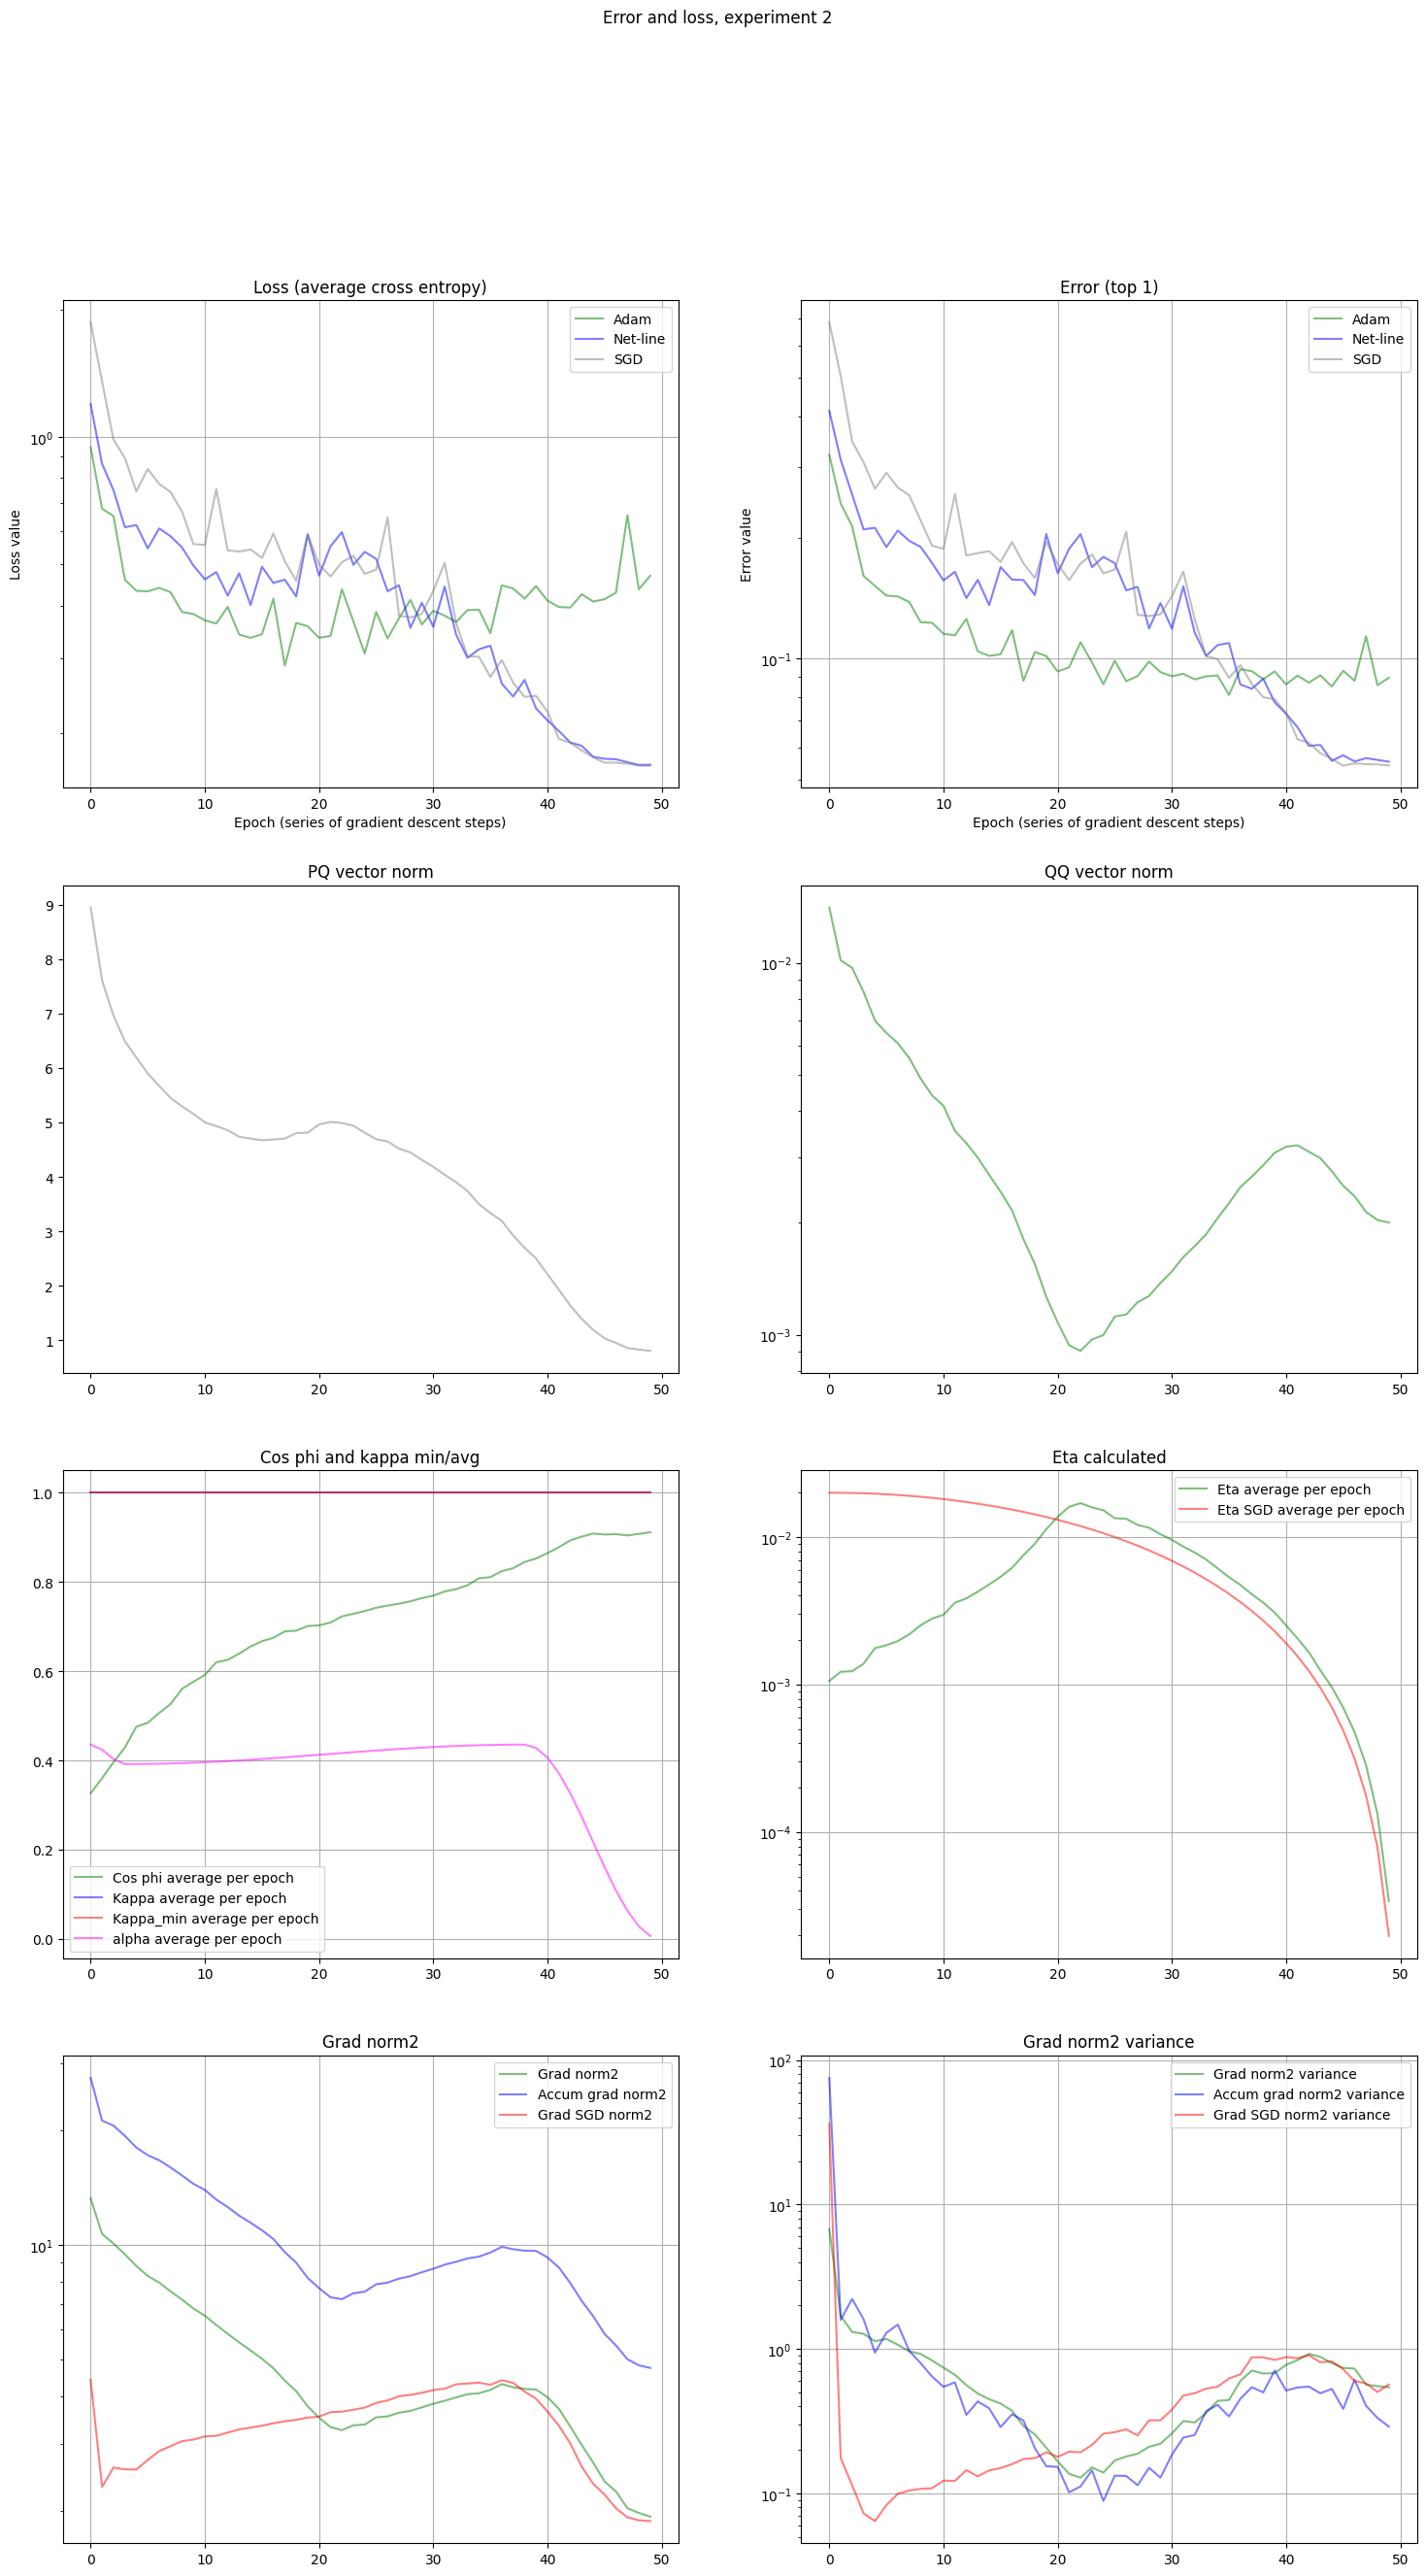

Experiment=0, sgd=0.9454380571842194, net-line=0.9473094701766968, adam=0.9076072216033936
Experiment=1, sgd=0.945806759595871, net-line=0.9469407677650452, adam=0.9111507475376129
Experiment=2, sgd=0.9458964407444, net-line=0.9447026431560517, adam=0.9105488657951355, alpha=0.0170370868554659, beta_min=9.999999747378752e-06, weight_decay=0.005


In [ ]:
meta = MetaData(batch_size = BATCH_SIZE, output_dim=OUTPUT_DIM, device=DEVICE)

'''
0-num of experiment; 1-epoch;
2-net: 0-Adam, 1-Net-line 2step, 2-SGD
3-param: 0-test accuracy (Top-1), 1-test errror (cross-entropy), 2-time per step, 3 - qq_norm_test,
4 - pq_norm, 5 - cos_phi, 6 - eta_calculated, 7 - alpha/lr(sgd), 8 - armiho_coeff, 9 - kappa avg, 10 - kappa min,
11 - grad_norm2_sq, 12 - grad_norm2_var, 13 - accum_norm2_sq, 14 - accum_norm2_var, 15 - alpha, 16 - empty
'''
experimental_results = np.zeros((EXPERIMENTS, EPOCHS_PER_EXPERIMENT, 3, 17))
eta_fixed = 0.01

for experiment in range(EXPERIMENTS):

    #Adam
    net_adam = make_resnet9(3, OUTPUT_DIM).to(DEVICE)
    loss_adam = nn.CrossEntropyLoss()
    opt_adam = optim.Adam(net_adam.parameters(), lr=0.001)

    #Net-line 2step
    net_linestep = copy.deepcopy(net_adam)
    opt_linestep = NetLineStepProcessor(net_linestep, meta, DEVICE)
    opt_linestep.eta1 = 0.00001
    opt_linestep.dropout_mode=False
    opt_linestep.do_logging=False
    opt_linestep.do_calc_armiho = False
    opt_linestep.do_calc_grad_norm2 = True
    opt_linestep.shorten_grad_accumulated=True

    #Sgd scheduled lr
    net_sgd = copy.deepcopy(net_adam)
    loss_sgd = nn.CrossEntropyLoss()
    opt_sgd = optim.SGD(net_sgd.parameters(), 0.02, momentum=0.9, weight_decay=5e-3)
    schd_sgd = optim.lr_scheduler.CosineAnnealingLR(opt_sgd, T_max=EPOCHS_PER_EXPERIMENT)

    for epoch in range(EPOCHS_PER_EXPERIMENT):
        #alpha, beta for net-line
        opt_linestep.alpha = cosine_annealing4_lr(1.0, 0.9, 1.0, 0.0, 0, 3, 38, 50, epoch)
        weight_decay0 = 5e-3

        mt_alpha, mt_agrad, mt_agrad_sq, mt_grad_sga_sq, mt_grad_sga, mt_grad_sga, mt_kappa, mt_kappa_min, mt_adam, mt_netline, mt_sgd, mt_qq, mt_pq, mt_cos, mt_eta, mt_grad_sq, mt_grad = \
            AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
        net_adam.train(True)
        net_linestep.train(True)
        net_sgd.train(True)

        for train_batch in train_dataloader:
            images, labels = train_batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logging.info("####Step with Adam, eta={}".format(opt_adam.param_groups[0]['lr']))
            ns_start = time.time_ns()
            logits0 = net_adam.forward(images)
            loss0 = loss_adam(logits0, labels)
            opt_adam.zero_grad()
            loss0.backward()
            opt_adam.step()
            ns_end = time.time_ns()
            mt_adam.update(ns_end-ns_start)

            logging.info("####Step with net-line 2step")
            ns_start = time.time_ns()
            step_result = opt_linestep.step(labels, images, momentum=0.9, weight_decay=weight_decay0)
            ns_end = time.time_ns()
            mt_netline.update(ns_end-ns_start)
            mt_pq.update(step_result.pq_norm)
            mt_qq.update(step_result.qq_norm)
            mt_cos.update(step_result.cos_phi)
            mt_eta.update(step_result.eta)
            mt_kappa.update(step_result.kappa_avg)
            mt_kappa_min.update(step_result.kappa_min)
            mt_grad.update(math.sqrt(step_result.grad_norm2_squared))
            mt_grad_sq.update(step_result.grad_norm2_squared)
            mt_agrad.update(math.sqrt(step_result.accum_norm2_squared))
            mt_agrad_sq.update(step_result.accum_norm2_squared)
            mt_alpha.update(step_result.alpha)

            logging.info("####Step with SGD, eta={}".format(opt_sgd.param_groups[0]['lr']))
            ns_start = time.time_ns()
            logits1 = net_sgd.forward(images)
            loss1 = loss_sgd(logits1, labels)
            opt_sgd.zero_grad()
            loss1.backward()
            opt_sgd.step()
            ns_end = time.time_ns()
            mt_sgd.update(ns_end-ns_start)
            # --calculate the gradient--
            sga_grad = 0.
            for p in net_sgd.parameters():
                sga_grad += ((p.grad)**2).sum().item()
            mt_grad_sga.update(math.sqrt(sga_grad))
            mt_grad_sga_sq.update(sga_grad)

        #qq_norm, pq_norm, cos_phi
        experimental_results[experiment, epoch, 1, 3] = mt_qq.avg
        experimental_results[experiment, epoch, 1, 4] = mt_pq.avg
        experimental_results[experiment, epoch, 1, 5] = mt_cos.avg
        experimental_results[experiment, epoch, 1, 6] = mt_eta.avg
        experimental_results[experiment, epoch, 1, 7] = opt_linestep.alpha
        experimental_results[experiment, epoch, 1, 8] = None
        experimental_results[experiment, epoch, 1, 9] = mt_kappa.avg
        experimental_results[experiment, epoch, 1, 10] = mt_kappa_min.avg
        experimental_results[experiment, epoch, 1, 11] = mt_grad.avg
        experimental_results[experiment, epoch, 1, 12] = mt_grad_sq.avg - (mt_grad.avg)**2
        experimental_results[experiment, epoch, 1, 13] = mt_agrad.avg
        experimental_results[experiment, epoch, 1, 14] = mt_agrad_sq.avg - (mt_agrad.avg)**2
        experimental_results[experiment, epoch, 1, 15] = mt_alpha.avg

        #timing
        experimental_results[experiment, epoch, 0, 2] = mt_adam.avg
        experimental_results[experiment, epoch, 1, 2] = mt_netline.avg
        experimental_results[experiment, epoch, 2, 2] = mt_sgd.avg

        # testing loop 0-Adam, 1-Net-line 2step, 2-SGD
        acc0, loss0 = test_loop(net_adam)
        experimental_results[experiment, epoch, 0, 0] = acc0
        experimental_results[experiment, epoch, 0, 1] = loss0

        acc1, loss1 = test_loop(net_linestep)
        experimental_results[experiment, epoch, 1, 0] = acc1
        experimental_results[experiment, epoch, 1, 1] = loss1

        acc2, loss2 = test_loop(net_sgd)
        experimental_results[experiment, epoch, 2, 0] = acc2
        experimental_results[experiment, epoch, 2, 1] = loss2
        experimental_results[experiment, epoch, 2, 6] = schd_sgd.get_last_lr()[0]
        experimental_results[experiment, epoch, 2, 11] = mt_grad_sga.avg
        experimental_results[experiment, epoch, 2, 12] = mt_grad_sga_sq.avg - (mt_grad_sga.avg)**2

        schd_sgd.step()

        display.clear_output()
        title="Error and loss, experiment {}".format(experiment)
        experiment_comparison(experimental_results[experiment, 0:epoch+1], 0, 100, title=title)

        epf = EPOCHS_PER_EXPERIMENT - 1
        for exp in range(experiment):
            print("Experiment={}, sgd={}, net-line={}, adam={}"\
                .format(exp, experimental_results[exp, epf, 2, 0]\
                        , experimental_results[exp, epf, 1, 0], experimental_results[exp, epf, 0, 0]))

        print("Experiment={}, sgd={}, net-line={}, adam={}, alpha={}, beta_min={}, weight_decay={}"\
            .format(experiment, acc2, acc1, acc0, opt_linestep.alpha, opt_linestep.beta_min, weight_decay0))


In [12]:
print("Accuracy in the latest experiment, net-line: \n{}".format(experimental_results[experiment, :, 1, 0]))

Accuracy in the latest experiment, net-line: 
[0.58692004 0.68787667 0.74412069 0.79048549 0.78861408 0.81066048
 0.79190051 0.80382454 0.81050502 0.82729791 0.84367028 0.83579799
 0.85871532 0.84318399 0.86425781 0.8312779  0.84289102 0.84334742
 0.85623007 0.79591039 0.8370456  0.81256976 0.79617347 0.83130979
 0.82103396 0.82745735 0.85235372 0.84932039 0.88133968 0.86275111
 0.88150311 0.84894173 0.88419563 0.89857103 0.8920719  0.8907665
 0.91391502 0.91599569 0.91103117 0.92228157 0.92720225 0.93260124
 0.93943718 0.93911431 0.94442363 0.94262994 0.94463488 0.94356067
 0.94412468 0.94470264]


In [13]:
print("Accuracy in the latest experiment, SGD: \n{}".format(experimental_results[experiment, :, 2, 0]))

Accuracy in the latest experiment, SGD: 
[0.3140625  0.49534239 0.65295161 0.6925562  0.73568638 0.71018415
 0.73378507 0.74529058 0.77960977 0.80919563 0.81257374 0.74343112
 0.81972457 0.81716558 0.81515067 0.82620974 0.80512596 0.8275012
 0.8414481  0.80475726 0.82839007 0.84333346 0.82780811 0.81858458
 0.83710738 0.83367347 0.79331752 0.87159598 0.87256058 0.87132095
 0.85736408 0.83555086 0.87497608 0.89875039 0.90040856 0.91064054
 0.90373086 0.9136081  0.91998366 0.92089844 0.92681162 0.9371014
 0.93843072 0.94192243 0.94381577 0.94596421 0.94523477 0.94546795
 0.94553571 0.94589644]


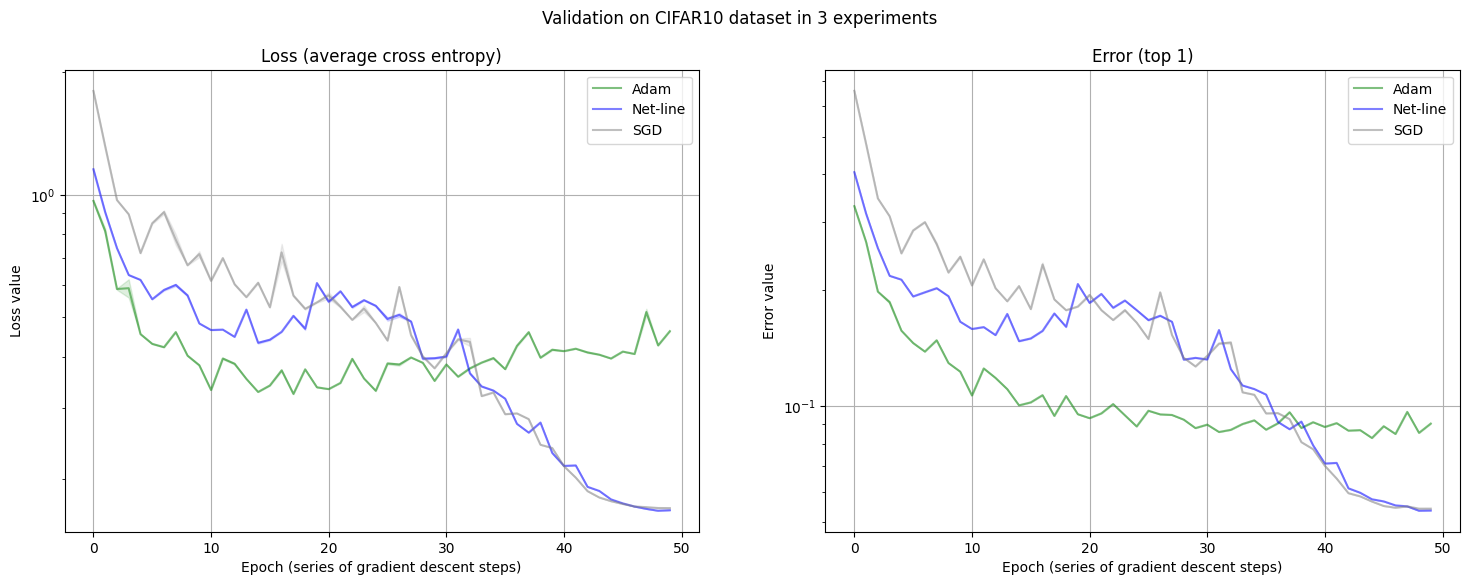

In [14]:
experimental_mean = np.mean(experimental_results, axis=0)
experimental_var = np.var(experimental_results, axis=0)

display.clear_output()
title2="Validation on CIFAR10 dataset in {} experiments".format(EXPERIMENTS)
experiments_comparison(experimental_mean[0:epoch+1], experimental_var[0:epoch+1], 0, 100, title=title2)


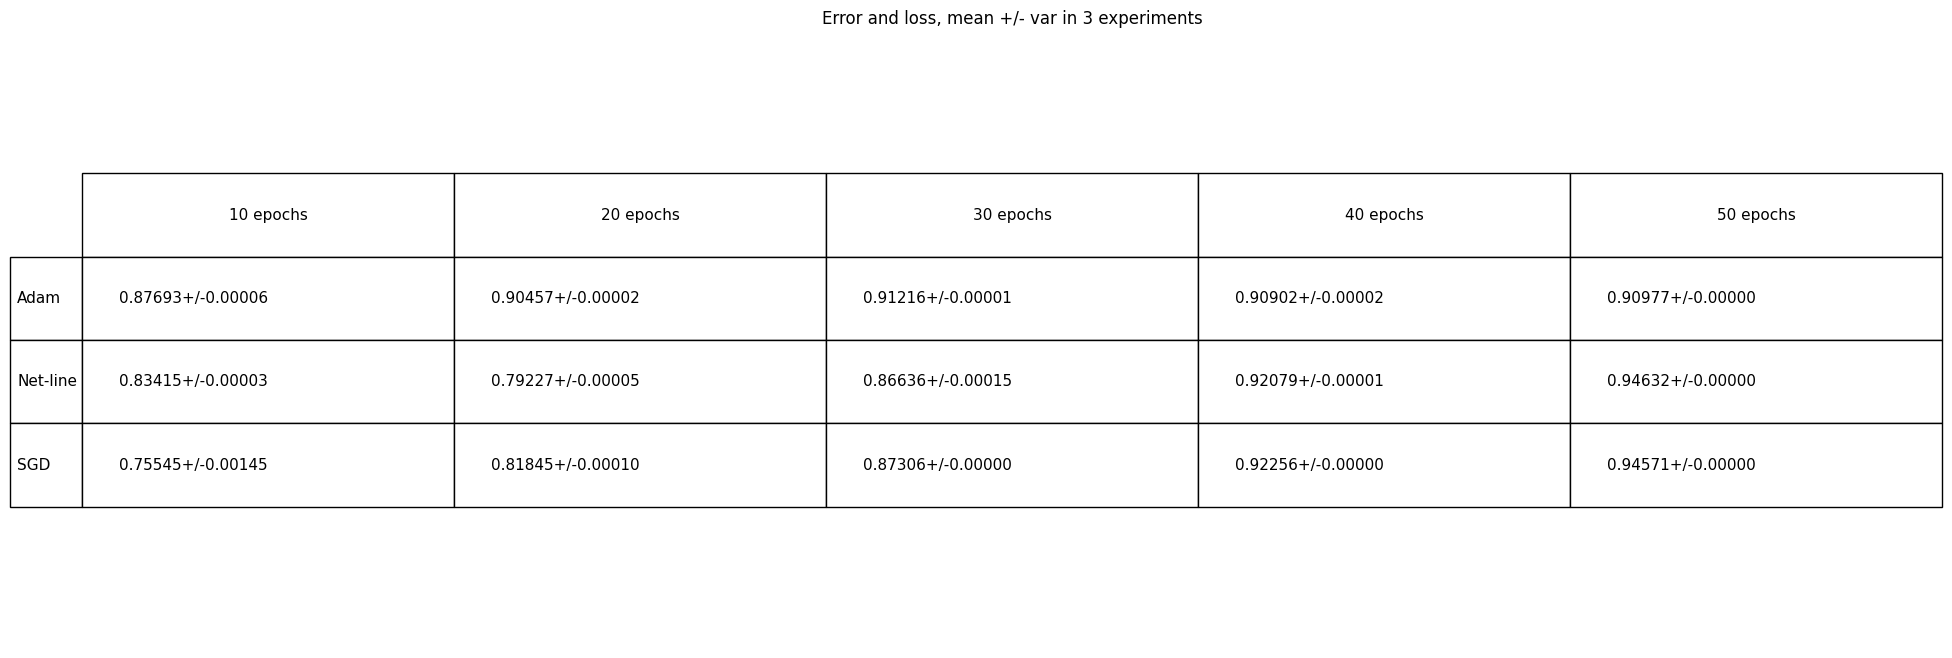

In [20]:
#experimental_results[2, 0:100, 1, 0]
title3 = "Error and loss, mean +/- var in {} experiments".format(EXPERIMENTS)
accuracy_comparison(experimental_results, 0, EPOCHS_PER_EXPERIMENT, title=title3)